#1 - Implementing the model





In [35]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F

from fastai.data.external import untar_data, URLs
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = True

Loading images

In [36]:
#!pip install fastai --upgrade

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initial Working Directory: /content/drive/My Drive
Directory contents:  ['Comp. Tools Data Science', 'Colab Notebooks', 'runs', 'events.out.tfevents.1700167182.b7687c2f0442.173.1', 'carseg_data', 'arrays']
Checking existence  None


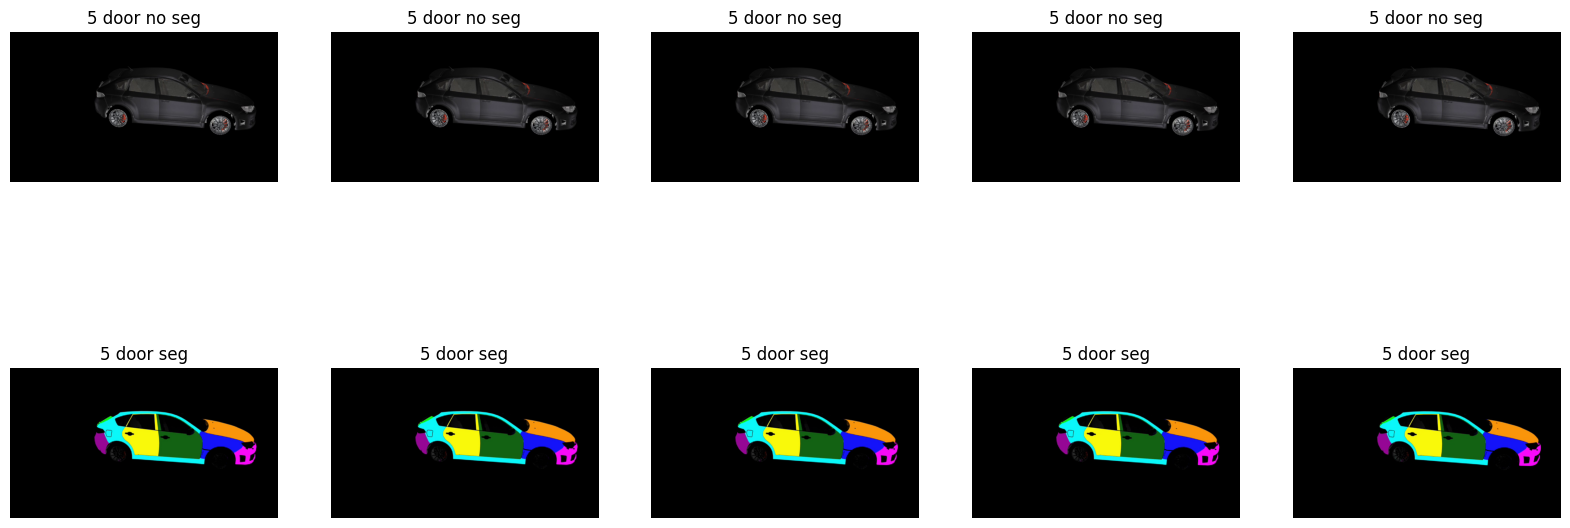

In [38]:
import os
from matplotlib.colors import ListedColormap
current_directory = os.getcwd()
print("Initial Working Directory:", current_directory)
print("Directory contents: ", os.listdir())
print("Checking existence ",os.chdir(r'/content/drive/MyDrive'))
#CHANGE TO YOUR DIRECTORY
image_path = r'/content/drive/MyDrive/carseg_data/carseg_data/images/black_5_doors/no_segmentation'
segmentation_path =r'/content/drive/MyDrive/carseg_data/carseg_data/images/black_5_doors/with_segmentation'

#CMAP for our segmentation
car_cmap = ListedColormap([(0,0,0),(250, 149, 10),
(19, 98, 19),
(249, 249, 10),
(10, 248, 250),
(149, 7, 149),
(5, 249, 9),
(20, 19, 249),
(249, 9, 250)])


image_files = sorted(os.listdir(image_path))[:5]
segmentation_files = sorted(os.listdir(segmentation_path))[:5]
i = 1
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for image_file, segmentation_file in zip(image_files, segmentation_files):
    image_file_path = os.path.join(image_path, image_file)
    segmentation_file_path = os.path.join(segmentation_path, segmentation_file)

    # Load and display the image
    img = Image.open(image_file_path)
    plt.subplot(2, 5, image_files.index(image_file) + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'5 door no seg')

    # Load and display the segmentation mask
    seg_mask = Image.open(segmentation_file_path)
    plt.subplot(2, 5, 5 + image_files.index(image_file) + 1)
    plt.imshow(seg_mask,cmap=car_cmap)
    plt.axis('off')
    plt.title(f'5 door seg')

    i +=1

plt.show()


In [39]:
from sklearn.model_selection import train_test_split

class CarDataset(Dataset):
    def __init__(self, image_dir, segmentation_dir, transform=None):
        self.image_dir = image_dir
        self.segmentation_dir = segmentation_dir
        self.transform = transform

        self.image_filenames = sorted(os.listdir(image_dir))
        self.segmentation_filenames = sorted(os.listdir(segmentation_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        if filename in os.listdir(self.image_dir):
            image_path = os.path.join(self.image_dir, filename)
        else:
            image_path = os.path.join(self.controls_dir, filename)
        segmentation_path = os.path.join(self.segmentation_dir, self.segmentation_filenames[idx])

        image = Image.open(image_path)  # Convert to grayscale
        segmentation = Image.open(segmentation_path)

        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)

        return {'car': image, 'segm_mask': segmentation}

def custom_collate(batch):
    # Resize images and masks to a common size
    batch_size = len(batch)
    max_height = max(item['car'].shape[1] for item in batch)
    max_width = max(item['car'].shape[2] for item in batch)

    # Pad images and masks to the maximum size
    padded_images = [torch.nn.functional.pad(item['car'], pad=(0, max_width - item['car'].shape[2], 0, max_height - item['car'].shape[1])) for item in batch]
    padded_masks = [torch.nn.functional.pad(item['segm_mask'], pad=(0, max_width - item['segm_mask'].shape[2], 0, max_height - item['segm_mask'].shape[1])) for item in batch]

    # Stack padded images and masks
    stacked_images = torch.stack(padded_images)
    stacked_masks = torch.stack(padded_masks)

    return {'car': stacked_images, 'segm_mask': stacked_masks}

# Define your data transformation (adjust as needed)
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

# Define your dataset instance
dataset = CarDataset(image_dir=image_path, segmentation_dir=segmentation_path, transform=transform)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, train_size=0.75, random_state=42)

# Define batch size
batch_size = 32 # Adjust as needed

# Create data loaders with the custom collate function
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=custom_collate)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)

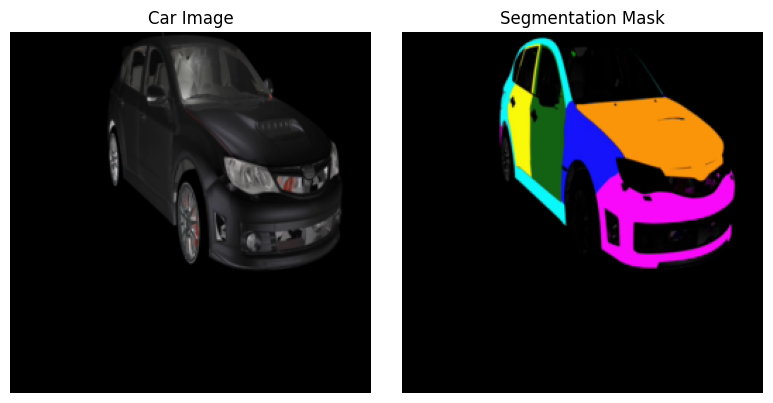

In [125]:
import matplotlib.pyplot as plt

# Fetch the first batch from val_dl
first_val_batch = next(iter(val_dl))
first_val_car = first_val_batch['car'][0].cpu().numpy()
first_val_segm = first_val_batch['segm_mask'][0].cpu().numpy()

# Display the first car image and its segmentation
plt.figure(figsize=(8, 4))

# Show the first car image
plt.subplot(1, 2, 1)
plt.title('Car Image')
plt.imshow(first_val_car.transpose(1, 2, 0))  # Assuming the shape is (C, H, W)
plt.axis('off')

# Show its segmentation mask
plt.subplot(1, 2, 2)
plt.title('Segmentation Mask')
plt.imshow(first_val_segm.transpose(1, 2, 0),cmap=car_cmap)  # Assuming the shape is (C, H, W)
plt.axis('off')

plt.tight_layout()
plt.show()


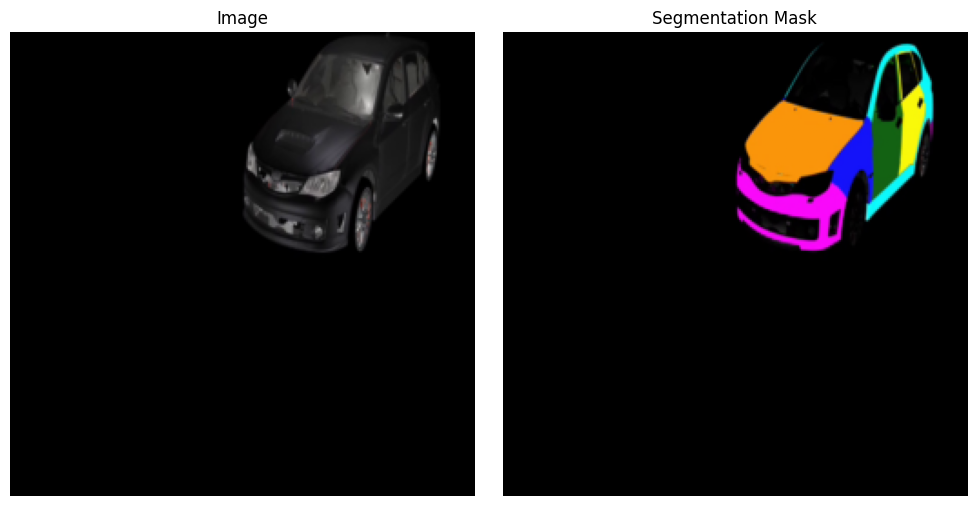

In [69]:
import matplotlib.pyplot as plt

# Assuming train_dl is your DataLoader
for batch_idx, batch_sample in enumerate(train_dl):
    # Access the images and segmentation masks in the batch
    images = batch_sample['car']
    masks = batch_sample['segm_mask']

    # Display the first image and its segmentation mask in the batch
    first_image = images[0].permute(1, 2, 0)  # Assuming tensor is in (batch, channel, height, width) format
    first_mask = masks[0].permute(1, 2, 0)

    # Convert tensors to numpy arrays for visualization
    first_image_np = first_image.cpu().detach().numpy()
    first_mask_np = first_mask.cpu().detach().numpy()

    # Plot the image and its segmentation mask
    plt.figure(figsize=(10, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(first_image_np)
    plt.axis('off')

    # Display the segmentation mask
    plt.subplot(1, 2, 2)
    plt.title('Segmentation Mask')
    plt.imshow(first_mask_np.squeeze(), cmap='jet')  # Assuming segmentation mask is single-channel
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Break after displaying the first batch for demonstration purposes
    break


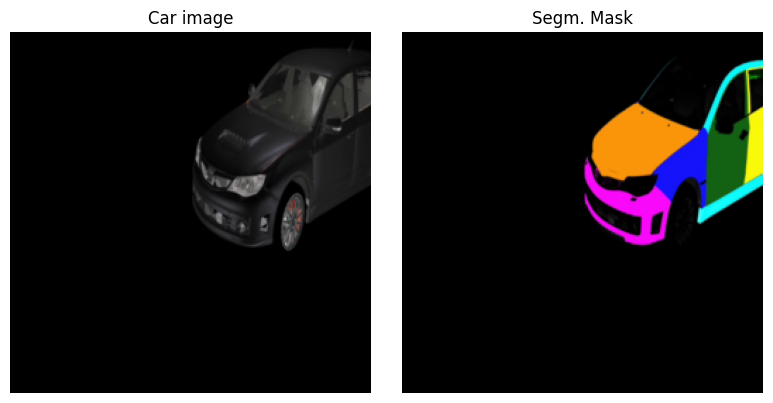

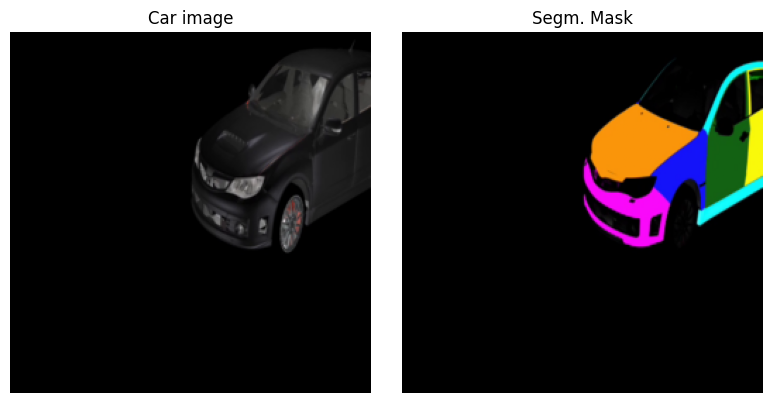

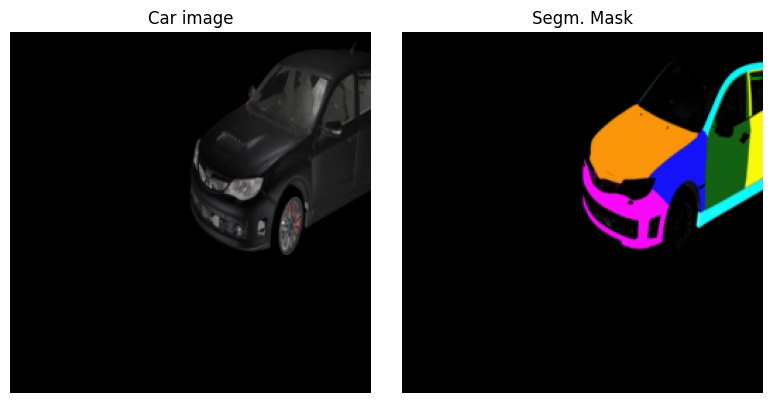

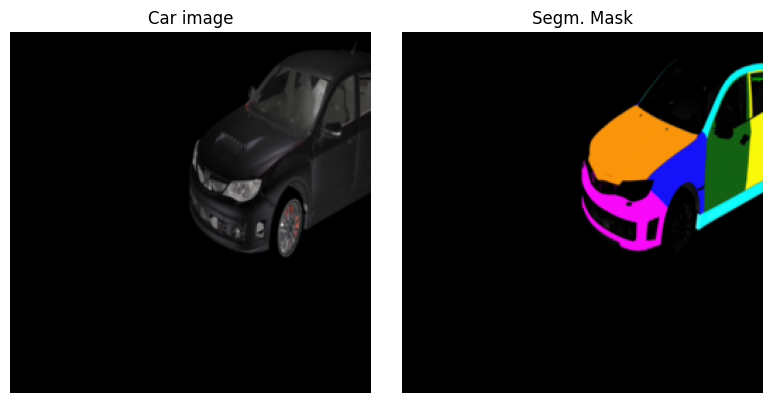

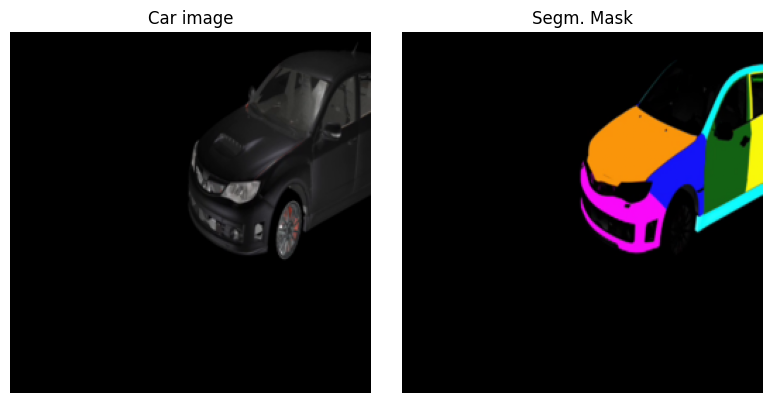

In [40]:


# Visualize the CT scans and their labels
for idx in range(110,115):
    data = dataset[idx]  # Get the data at the sampled index
    car = data['car']  # Extract the CT scan
    segm_mask = data['segm_mask'].squeeze(0)  # Extract the tumor mask

    # Convert to NumPy arrays if needed (assuming they are PIL images)
    #segm_mask = Image.open(segm_mask)
    #car = Image.open(car)
    # Plotting CT scan
    car = torch.permute(car,(1,2,0))
    segm_mask = torch.permute(segm_mask, (1,2,0))
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(car)
    plt.title('Car image')
    plt.axis('off')

    # Plotting tumor mask
    plt.subplot(1, 2, 2)
    plt.imshow(segm_mask)
    plt.title('Segm. Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [113]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, activation=None ):
        super(ConvLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),nn.LeakyReLU(0.2, inplace=True)
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class TransposeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, flag, kernel_size=4, stride=2, padding=1, bias=False):
        super(TransposeConvLayer, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if flag == 1:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        print(nf)
        downconv = ConvLayer(input_c, ni)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(inplace=True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = TransposeConvLayer(ni * 2, nf, flag = 1)
            down = [downconv]
            up = [upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = TransposeConvLayer(ni, nf, bias=False, flag = 0)
            down = [downconv]
            up = [upconv, upnorm]
            model = down + up
        else:
            upconv = TransposeConvLayer(ni * 2, nf, bias=False, flag = 0)
            down = [downconv, downnorm]
            up = [upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
        self.residual = nn.Sequential(
            nn.Conv2d(input_c, nf, kernel_size=1, stride=1),
            nn.BatchNorm2d(nf)
        )

    def forward(self, x):
        if self.outermost:
            output = self.model(x)
            return output
        else:
            x_clone = x.clone()
            residual_output = self.residual(x_clone)
            model_output = self.model(x)
            concatenated_output = torch.cat([residual_output, model_output], 1)
            return concatenated_output


class Unet(nn.Module):
    def __init__(self, input_c=3, output_c=3, n_down=8, num_filters=64):
        super(Unet, self).__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):

        #out = (0.5 - 1e-7) * torch.erf(self.model(x)/torch.sqrt(torch.tensor(2)))
        #x = nn.Softmax(dim=1)(self.model(x))
        out = self.model(x)
        return out


##Weights
We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article

In [114]:
def init_weights(net, init='norm', gain=0.1, print_message=True):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

        if 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    if print_message:
        print(f"model initialized with {init} initialization")
    return net

def init_model(model, device, init_type='norm', gain=0.02):
    model = model.to(device)
    model = init_weights(model, init=init_type, gain=gain)
    return model


## Dice Loss

In [43]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-8  # Smoothing value to prevent division by zero
        input_flat = input.view(-1)
        target_flat = target.view(-1)
        intersection = (input_flat * target_flat).sum()
        dice_coeff = (2.0 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        dice_loss = 1.0 - dice_coeff
        return dice_loss


## Main model

In [115]:
import sys
import torch.nn.functional as F

np.set_printoptions(threshold=np.inf)
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=1e-4,
                 beta1=0.95, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=3, output_c=3, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))

        self.LossFunction = DiceLoss()  # Change loss function for segmentation

    def set_requires_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = True

    def setup_input(self, data):
        self.car = data['car'].to(self.device)
        self.segm_mask = data['segm_mask'].to(self.device)

    def forward(self):

        self.predicted_segm_mask = self.net_G(self.car)

    def backward_G(self):

        predicted_flat = self.predicted_segm_mask.view(-1)  # Flatten predicted tensor
        target_flat = self.segm_mask.view(-1)  # Flatten target tens

        self.seg_loss = self.LossFunction(predicted_flat,target_flat)
        self.total_loss = self.seg_loss * self.lambda_L1

        #print("Total Loss:", self.total_loss.item())

        self.opt_G.zero_grad()
        self.total_loss.backward()
        self.opt_G.step()

    def optimize(self):
        self.forward()
        self.opt_G.zero_grad()
        self.net_G.train()
        self.backward_G()
        self.opt_G.step() #Double step, check if needed



The MeasureClass class is a utility class for computing and tracking the average of a value over multiple iterations. It keeps track of the count, sum, and average of the values. The reset method resets the meter, while the update method updates the meter with a new value and count.



## Measures

In [45]:
#pip install tensorboard

In [116]:
from torch.utils.tensorboard import SummaryWriter

class MeasureClass:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    total_loss = MeasureClass()

    return {
            'total_loss': total_loss}

def update_losses(model, loss_meter_dict, count, writer, step):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        writer.add_scalar(loss_name, loss_meter.avg, step)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)


def log_results(loss_meter_dict, step, writer):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        writer.add_scalar(loss_name, loss_meter.avg, step)

##1.8- Training function


512
512
512
512
256
128
64
3
model initialized with norm initialization


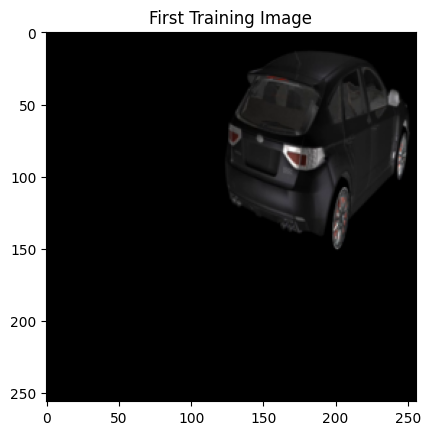

  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 86.11897
total_loss: 80.59599
total_loss: 76.61423
total_loss: 73.35406
total_loss: 71.09600
total_loss: 69.21821
total_loss: 67.86494
total_loss: 66.70343
total_loss: 65.70198
total_loss: 64.94783
total_loss: 64.26032
total_loss: 63.73020
total_loss: 63.11946
total_loss: 62.60127
total_loss: 61.93693
total_loss: 61.26329
total_loss: 60.72755
total_loss: 60.16490
total_loss: 59.63079
total_loss: 59.32570
Epoch  1


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 54.73077
total_loss: 52.08662
total_loss: 52.54083
total_loss: 52.32507
total_loss: 52.56564
total_loss: 52.67662
total_loss: 52.53236
total_loss: 52.44082
total_loss: 52.35218
total_loss: 52.33958
total_loss: 52.05124
total_loss: 52.04737
total_loss: 52.12218
total_loss: 51.75381
total_loss: 51.56966
total_loss: 51.44016
total_loss: 51.14383
total_loss: 50.92486
total_loss: 50.71358
total_loss: 50.60504
Epoch  2


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 44.31588
total_loss: 45.47997
total_loss: 46.19059
total_loss: 45.58502
total_loss: 45.86928
total_loss: 45.88612
total_loss: 45.91871
total_loss: 45.76673
total_loss: 45.52292
total_loss: 45.50262
total_loss: 45.60765
total_loss: 45.36719
total_loss: 45.38951
total_loss: 45.41831
total_loss: 45.49021
total_loss: 45.60197
total_loss: 45.41524
total_loss: 45.34032
total_loss: 45.25718
total_loss: 45.25936
Epoch  3


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 46.24747
total_loss: 44.88610
total_loss: 44.09734
total_loss: 43.55286
total_loss: 43.37612
total_loss: 43.01607
total_loss: 43.15042
total_loss: 43.11143
total_loss: 43.02435
total_loss: 42.90999
total_loss: 42.91561
total_loss: 42.91714
total_loss: 42.75238
total_loss: 42.90606
total_loss: 42.81935
total_loss: 42.75052
total_loss: 42.83822
total_loss: 43.00361
total_loss: 43.10985
total_loss: 43.13527
Epoch  4


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 41.04184
total_loss: 41.84458
total_loss: 42.12737
total_loss: 42.09724
total_loss: 42.00096
total_loss: 42.03989
total_loss: 41.94937
total_loss: 41.95613
total_loss: 42.00683
total_loss: 41.87217
total_loss: 41.83516
total_loss: 41.79735
total_loss: 41.77518
total_loss: 41.64349
total_loss: 41.64371
total_loss: 41.63488
total_loss: 41.60011
total_loss: 41.51263
total_loss: 41.51195
total_loss: 41.43901
Epoch  5


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 41.34354
total_loss: 41.58382
total_loss: 40.67617
total_loss: 40.44739
total_loss: 40.38720
total_loss: 40.16240
total_loss: 40.04351
total_loss: 39.95249
total_loss: 39.96507
total_loss: 39.89683
total_loss: 39.72896
total_loss: 39.82746
total_loss: 39.70426
total_loss: 39.70798
total_loss: 39.60160
total_loss: 39.49551
total_loss: 39.52815
total_loss: 39.49685
total_loss: 39.42258
total_loss: 39.39221
Epoch  6


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 38.05518
total_loss: 38.74185
total_loss: 38.43748
total_loss: 38.63618
total_loss: 38.99755
total_loss: 39.38734
total_loss: 39.52789
total_loss: 39.53470
total_loss: 39.53670
total_loss: 39.61402
total_loss: 39.49923
total_loss: 39.62557
total_loss: 39.42591
total_loss: 39.28982
total_loss: 39.30066
total_loss: 39.42839
total_loss: 39.43442
total_loss: 39.32251
total_loss: 39.39630
total_loss: 39.44131
Epoch  7


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 37.89270
total_loss: 37.62135
total_loss: 37.29427
total_loss: 37.95954
total_loss: 37.78675
total_loss: 37.98084
total_loss: 37.81316
total_loss: 37.76636
total_loss: 37.62155
total_loss: 37.85588
total_loss: 37.81176
total_loss: 37.73003
total_loss: 37.70386
total_loss: 37.66389
total_loss: 37.62944
total_loss: 37.47033
total_loss: 37.37119
total_loss: 37.39074
total_loss: 37.42269
total_loss: 37.34984
Epoch  8


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 35.92361
total_loss: 36.11527
total_loss: 35.95687
total_loss: 36.49362
total_loss: 36.41945
total_loss: 36.51669
total_loss: 36.70363
total_loss: 37.03904
total_loss: 37.04941
total_loss: 37.08798
total_loss: 36.95525
total_loss: 37.16015
total_loss: 36.96569
total_loss: 36.92365
total_loss: 36.81876
total_loss: 36.75194
total_loss: 36.66997
total_loss: 36.64634
total_loss: 36.58574
total_loss: 36.55698
Epoch  9


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 34.40755
total_loss: 34.99161
total_loss: 35.26433
total_loss: 35.00779
total_loss: 35.12514
total_loss: 35.03797
total_loss: 34.87768
total_loss: 34.86582
total_loss: 34.79738
total_loss: 34.70349
total_loss: 34.60100
total_loss: 34.58632
total_loss: 34.55808
total_loss: 34.44142
total_loss: 34.38262
total_loss: 34.34061
total_loss: 34.33727
total_loss: 34.22155
total_loss: 34.16026
total_loss: 34.24209
Epoch  10


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 32.89188
total_loss: 32.86330
total_loss: 33.27043
total_loss: 33.44801
total_loss: 33.42573
total_loss: 33.49793
total_loss: 33.96390
total_loss: 33.79625
total_loss: 33.61393
total_loss: 33.39833
total_loss: 33.28092
total_loss: 33.21026
total_loss: 33.23635
total_loss: 33.22295
total_loss: 33.24919
total_loss: 33.09274
total_loss: 32.99974
total_loss: 33.06046
total_loss: 32.96489
total_loss: 32.94393
Epoch  11


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 33.12576
total_loss: 32.94184
total_loss: 32.52440
total_loss: 32.50650
total_loss: 32.42897
total_loss: 32.54264
total_loss: 32.71818
total_loss: 32.58683
total_loss: 32.49738
total_loss: 32.62728
total_loss: 32.48486
total_loss: 32.36347
total_loss: 32.28746
total_loss: 32.08929
total_loss: 32.21931
total_loss: 32.21150
total_loss: 32.25992
total_loss: 32.22003
total_loss: 32.20346
total_loss: 32.15414
Epoch  12


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 31.02005
total_loss: 32.31695
total_loss: 32.08282
total_loss: 32.00572
total_loss: 32.23347
total_loss: 32.14142
total_loss: 31.91809
total_loss: 31.55231
total_loss: 31.60067
total_loss: 31.54898
total_loss: 31.40468
total_loss: 31.16712
total_loss: 31.03256
total_loss: 30.98732
total_loss: 30.86319
total_loss: 30.81715
total_loss: 30.67099
total_loss: 30.57749
total_loss: 30.58137
total_loss: 30.49654
Epoch  13


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 29.15092
total_loss: 29.68796
total_loss: 29.68032
total_loss: 29.45643
total_loss: 29.29345
total_loss: 29.18060
total_loss: 29.20313
total_loss: 29.30833
total_loss: 29.29745
total_loss: 29.49991
total_loss: 29.40660
total_loss: 29.44888
total_loss: 29.68877
total_loss: 29.58574
total_loss: 29.63600
total_loss: 29.53474
total_loss: 29.54337
total_loss: 29.51118
total_loss: 29.52008
total_loss: 29.48375
Epoch  14


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 28.04566
total_loss: 29.11049
total_loss: 28.96467
total_loss: 28.79160
total_loss: 28.67273
total_loss: 28.67205
total_loss: 28.54410
total_loss: 28.93781
total_loss: 29.08517
total_loss: 28.91955
total_loss: 28.83592
total_loss: 28.81782
total_loss: 28.84320
total_loss: 28.86679
total_loss: 28.83961
total_loss: 28.82328
total_loss: 28.74216
total_loss: 28.69264
total_loss: 28.74948
total_loss: 28.72771
Epoch  15


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 28.03785
total_loss: 28.51266
total_loss: 27.85864
total_loss: 27.55798
total_loss: 27.50547
total_loss: 27.71842
total_loss: 27.86546
total_loss: 27.92790
total_loss: 27.97988
total_loss: 27.81626
total_loss: 27.85657
total_loss: 27.77501
total_loss: 27.72317
total_loss: 27.69993
total_loss: 27.58705
total_loss: 27.59039
total_loss: 27.57075
total_loss: 27.57882
total_loss: 27.57849
total_loss: 27.55815
Epoch  16


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 26.98637
total_loss: 27.37543
total_loss: 27.33791
total_loss: 27.31621
total_loss: 26.96534
total_loss: 27.00100
total_loss: 26.90821
total_loss: 26.81550
total_loss: 26.91122
total_loss: 26.83398
total_loss: 26.71517
total_loss: 26.56199
total_loss: 26.58360
total_loss: 26.52637
total_loss: 26.51631
total_loss: 26.48225
total_loss: 26.41290
total_loss: 26.39643
total_loss: 26.41235
total_loss: 26.44629
Epoch  17


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 26.75524
total_loss: 26.65885
total_loss: 26.19370
total_loss: 26.16697
total_loss: 25.81933
total_loss: 25.78927
total_loss: 25.95602
total_loss: 25.87093
total_loss: 25.95162
total_loss: 25.80444
total_loss: 25.84207
total_loss: 25.81479
total_loss: 25.83288
total_loss: 25.80919
total_loss: 25.78057
total_loss: 25.80827
total_loss: 25.77521
total_loss: 25.75340
total_loss: 25.75357
total_loss: 25.74329
Epoch  18


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 24.97717
total_loss: 24.74105
total_loss: 24.55849
total_loss: 24.89100
total_loss: 25.00491
total_loss: 25.11488
total_loss: 25.24752
total_loss: 25.36574
total_loss: 25.42659
total_loss: 25.53886
total_loss: 25.59578
total_loss: 25.58691
total_loss: 25.54749
total_loss: 25.46986
total_loss: 25.47557
total_loss: 25.43151
total_loss: 25.48243
total_loss: 25.42943
total_loss: 25.43076
total_loss: 25.37713
Epoch  19


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 27.24621
total_loss: 26.21252
total_loss: 25.97989
total_loss: 25.96517
total_loss: 25.66481
total_loss: 25.67763
total_loss: 25.56488
total_loss: 25.63163
total_loss: 25.78105
total_loss: 25.80109
total_loss: 25.67873
total_loss: 25.69358
total_loss: 25.62664
total_loss: 25.62162
total_loss: 25.62253
total_loss: 25.56346
total_loss: 25.46091
total_loss: 25.47795
total_loss: 25.40481
total_loss: 25.49556
Epoch  20


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 23.84377
total_loss: 25.57051
total_loss: 25.74251
total_loss: 25.80808
total_loss: 25.64933
total_loss: 25.61049
total_loss: 25.62021
total_loss: 25.54210
total_loss: 25.59040
total_loss: 25.62428
total_loss: 25.57400
total_loss: 25.45457
total_loss: 25.34796
total_loss: 25.46632
total_loss: 25.49956
total_loss: 25.46224
total_loss: 25.38625
total_loss: 25.35066
total_loss: 25.36471
total_loss: 25.36133
Epoch  21


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 24.38850
total_loss: 24.85288
total_loss: 24.91770
total_loss: 24.66171
total_loss: 24.44070
total_loss: 24.37492
total_loss: 24.50096
total_loss: 24.44364
total_loss: 24.42039
total_loss: 24.32092
total_loss: 24.26000
total_loss: 24.27485
total_loss: 24.34515
total_loss: 24.27302
total_loss: 24.22179
total_loss: 24.07692
total_loss: 24.09799
total_loss: 24.11570
total_loss: 24.06047
total_loss: 24.03574
Epoch  22


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 23.99783
total_loss: 23.62795
total_loss: 23.61513
total_loss: 23.52512
total_loss: 23.35845
total_loss: 23.37088
total_loss: 23.47876
total_loss: 23.42544
total_loss: 23.44388
total_loss: 23.48410
total_loss: 23.52616
total_loss: 23.51875
total_loss: 23.36114
total_loss: 23.38953
total_loss: 23.34612
total_loss: 23.35312
total_loss: 23.25028
total_loss: 23.24430
total_loss: 23.30500
total_loss: 23.30384
Epoch  23


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 23.06269
total_loss: 22.97100
total_loss: 22.53020
total_loss: 22.63138
total_loss: 22.59780
total_loss: 22.68290
total_loss: 22.72833
total_loss: 22.75015
total_loss: 22.82745
total_loss: 22.86658
total_loss: 22.77133
total_loss: 22.75080
total_loss: 22.77526
total_loss: 22.74609
total_loss: 22.72459
total_loss: 22.72652
total_loss: 22.71950
total_loss: 22.75549
total_loss: 22.71514
total_loss: 22.73519
Epoch  24


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 22.88873
total_loss: 22.45711
total_loss: 22.20709
total_loss: 22.25565
total_loss: 22.74528
total_loss: 22.67242
total_loss: 22.51057
total_loss: 22.43364
total_loss: 22.42118
total_loss: 22.36295
total_loss: 22.32048
total_loss: 22.31409
total_loss: 22.40957
total_loss: 22.44308
total_loss: 22.51161
total_loss: 22.54447
total_loss: 22.65662
total_loss: 22.70523
total_loss: 22.68648
total_loss: 22.66694
Epoch  25


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 22.26889
total_loss: 21.64986
total_loss: 21.66021
total_loss: 21.74827
total_loss: 21.66802
total_loss: 21.77867
total_loss: 21.75748
total_loss: 21.91304
total_loss: 22.03088
total_loss: 22.04294
total_loss: 22.08279
total_loss: 21.98419
total_loss: 22.00797
total_loss: 22.04449
total_loss: 22.09560
total_loss: 22.21957
total_loss: 22.25820
total_loss: 22.28797
total_loss: 22.32583
total_loss: 22.37988
Epoch  26


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 22.88282
total_loss: 22.55023
total_loss: 22.32399
total_loss: 22.49458
total_loss: 22.73000
total_loss: 22.43587
total_loss: 22.29883
total_loss: 22.18239
total_loss: 22.21917
total_loss: 22.19114
total_loss: 22.30368
total_loss: 22.42868
total_loss: 22.47280
total_loss: 22.48756
total_loss: 22.57614
total_loss: 22.52866
total_loss: 22.46370
total_loss: 22.45633
total_loss: 22.43427
total_loss: 22.44338
Epoch  27


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 21.35587
total_loss: 22.65183
total_loss: 22.51605
total_loss: 22.29739
total_loss: 22.03773
total_loss: 22.22016
total_loss: 22.32749
total_loss: 22.17082
total_loss: 22.09965
total_loss: 22.12104
total_loss: 22.04720
total_loss: 22.04311
total_loss: 22.00403
total_loss: 22.08657
total_loss: 22.01678
total_loss: 21.95765
total_loss: 22.00866
total_loss: 22.01199
total_loss: 22.02689
total_loss: 21.99536
Epoch  28


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 21.68766
total_loss: 21.42888
total_loss: 21.68167
total_loss: 21.37183
total_loss: 21.69721
total_loss: 21.66728
total_loss: 21.59198
total_loss: 21.87596
total_loss: 21.86078
total_loss: 21.78046
total_loss: 21.80177
total_loss: 21.82809
total_loss: 21.88852
total_loss: 21.84540
total_loss: 21.79998
total_loss: 21.81597
total_loss: 21.78993
total_loss: 21.81868
total_loss: 21.85643
total_loss: 21.90640
Epoch  29


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 21.77733
total_loss: 20.75230
total_loss: 20.98224
total_loss: 21.18454
total_loss: 21.29297
total_loss: 21.15270
total_loss: 21.48904
total_loss: 21.48419
total_loss: 21.40951
total_loss: 21.46116
total_loss: 21.57899
total_loss: 21.61795
total_loss: 21.66850
total_loss: 21.59491
total_loss: 21.64844
total_loss: 21.54013
total_loss: 21.59207
total_loss: 21.59917
total_loss: 21.62579
total_loss: 21.62785
Epoch  30


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 21.36904
total_loss: 22.01865
total_loss: 21.53606
total_loss: 21.57304
total_loss: 21.69348
total_loss: 21.80965
total_loss: 21.69555
total_loss: 21.67549
total_loss: 21.50806
total_loss: 21.51850
total_loss: 21.38608
total_loss: 21.42134
total_loss: 21.38517
total_loss: 21.46296
total_loss: 21.40358
total_loss: 21.36289
total_loss: 21.42422
total_loss: 21.47732
total_loss: 21.48349
total_loss: 21.52354
Epoch  31


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 21.04812
total_loss: 21.02598
total_loss: 20.96877
total_loss: 21.43599
total_loss: 21.57081
total_loss: 21.61662
total_loss: 21.58399
total_loss: 21.45523
total_loss: 21.44398
total_loss: 21.46312
total_loss: 21.40551
total_loss: 21.32896
total_loss: 21.37006
total_loss: 21.45242
total_loss: 21.45189
total_loss: 21.41602
total_loss: 21.33786
total_loss: 21.28803
total_loss: 21.30465
total_loss: 21.30428
Epoch  32


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.06537
total_loss: 20.07538
total_loss: 20.42159
total_loss: 20.76539
total_loss: 21.00864
total_loss: 21.04347
total_loss: 20.87306
total_loss: 20.79617
total_loss: 20.76807
total_loss: 20.74194
total_loss: 20.82936
total_loss: 20.77957
total_loss: 20.78182
total_loss: 20.78160
total_loss: 20.82775
total_loss: 20.91848
total_loss: 20.96758
total_loss: 21.03697
total_loss: 21.03054
total_loss: 21.07524
Epoch  33


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.40959
total_loss: 20.59181
total_loss: 20.91289
total_loss: 21.11152
total_loss: 21.12305
total_loss: 21.13030
total_loss: 20.93756
total_loss: 20.93736
total_loss: 20.95331
total_loss: 20.88599
total_loss: 20.81472
total_loss: 20.90580
total_loss: 20.87154
total_loss: 20.82070
total_loss: 20.82913
total_loss: 20.72587
total_loss: 20.75680
total_loss: 20.83681
total_loss: 20.81890
total_loss: 20.83149
Epoch  34


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.83493
total_loss: 20.87541
total_loss: 20.40257
total_loss: 20.35969
total_loss: 20.20536
total_loss: 20.45944
total_loss: 20.32001
total_loss: 20.35446
total_loss: 20.47233
total_loss: 20.54055
total_loss: 20.54744
total_loss: 20.52562
total_loss: 20.61205
total_loss: 20.60973
total_loss: 20.73857
total_loss: 20.67704
total_loss: 20.69333
total_loss: 20.77767
total_loss: 20.81651
total_loss: 20.81894
Epoch  35


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.63557
total_loss: 20.99101
total_loss: 21.05400
total_loss: 21.03836
total_loss: 20.82896
total_loss: 20.85175
total_loss: 20.66455
total_loss: 20.72873
total_loss: 20.77273
total_loss: 20.64257
total_loss: 20.64156
total_loss: 20.62735
total_loss: 20.55500
total_loss: 20.57728
total_loss: 20.58387
total_loss: 20.59351
total_loss: 20.56648
total_loss: 20.58002
total_loss: 20.65382
total_loss: 20.63254
Epoch  36


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.56093
total_loss: 19.86907
total_loss: 19.63435
total_loss: 19.93574
total_loss: 20.09661
total_loss: 20.11621
total_loss: 20.19362
total_loss: 20.32553
total_loss: 20.35943
total_loss: 20.32656
total_loss: 20.33627
total_loss: 20.35354
total_loss: 20.34501
total_loss: 20.50238
total_loss: 20.47520
total_loss: 20.44449
total_loss: 20.38428
total_loss: 20.37719
total_loss: 20.34374
total_loss: 20.31650
Epoch  37


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 18.96555
total_loss: 19.57108
total_loss: 19.53420
total_loss: 19.60302
total_loss: 19.77000
total_loss: 19.85890
total_loss: 19.98485
total_loss: 20.06591
total_loss: 20.12508
total_loss: 20.19837
total_loss: 20.17407
total_loss: 20.13277
total_loss: 20.22553
total_loss: 20.18319
total_loss: 20.18062
total_loss: 20.14856
total_loss: 20.17574
total_loss: 20.20679
total_loss: 20.18715
total_loss: 20.20599
Epoch  38


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.59674
total_loss: 20.29107
total_loss: 20.27241
total_loss: 20.23139
total_loss: 20.05464
total_loss: 20.11349
total_loss: 20.19410
total_loss: 19.96484
total_loss: 20.01867
total_loss: 19.97567
total_loss: 20.12895
total_loss: 20.16428
total_loss: 20.09516
total_loss: 20.13966
total_loss: 20.08767
total_loss: 20.16460
total_loss: 20.22067
total_loss: 20.19228
total_loss: 20.16453
total_loss: 20.19731
Epoch  39


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.38175
total_loss: 20.68520
total_loss: 20.59520
total_loss: 20.32547
total_loss: 20.54806
total_loss: 20.43331
total_loss: 20.26488
total_loss: 20.14831
total_loss: 20.18094
total_loss: 20.10737
total_loss: 20.08480
total_loss: 20.17253
total_loss: 20.18820
total_loss: 20.20565
total_loss: 20.19185
total_loss: 20.14685
total_loss: 20.09212
total_loss: 20.07700
total_loss: 20.02403
total_loss: 20.01103
Epoch  40


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 19.27190
total_loss: 19.32901
total_loss: 19.33809
total_loss: 19.42505
total_loss: 19.46970
total_loss: 20.08469
total_loss: 20.05583
total_loss: 19.86010
total_loss: 19.97861
total_loss: 20.23948
total_loss: 20.26684
total_loss: 20.18353
total_loss: 20.17361
total_loss: 20.20156
total_loss: 20.15147
total_loss: 20.16771
total_loss: 20.20023
total_loss: 20.18951
total_loss: 20.18133
total_loss: 20.13502
Epoch  41


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 21.63032
total_loss: 20.76549
total_loss: 20.58287
total_loss: 20.61242
total_loss: 20.50944
total_loss: 20.33196
total_loss: 20.25974
total_loss: 20.31604
total_loss: 20.32753
total_loss: 20.47208
total_loss: 20.43951
total_loss: 20.42381
total_loss: 20.36499
total_loss: 20.34274
total_loss: 20.32996
total_loss: 20.26966
total_loss: 20.20166
total_loss: 20.16995
total_loss: 20.13972
total_loss: 20.15323
Epoch  42


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 19.15122
total_loss: 18.99908
total_loss: 18.98166
total_loss: 19.32914
total_loss: 19.50672
total_loss: 19.51338
total_loss: 19.68596
total_loss: 19.69319
total_loss: 19.82067
total_loss: 19.85559
total_loss: 19.81654
total_loss: 20.02889
total_loss: 20.13929
total_loss: 20.04516
total_loss: 20.12931
total_loss: 20.05382
total_loss: 20.07493
total_loss: 20.07373
total_loss: 20.03476
total_loss: 20.06038
Epoch  43


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 20.04087
total_loss: 20.01668
total_loss: 20.29966
total_loss: 20.33057
total_loss: 20.07996
total_loss: 20.23381
total_loss: 20.15745
total_loss: 19.97515
total_loss: 19.97610
total_loss: 19.97086
total_loss: 19.92640
total_loss: 19.93079
total_loss: 19.93151
total_loss: 19.79428
total_loss: 19.77913
total_loss: 19.72685
total_loss: 19.69426
total_loss: 19.67196
total_loss: 19.72680
total_loss: 19.69781
Epoch  44


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 19.14914
total_loss: 19.24802
total_loss: 19.21919
total_loss: 19.08744
total_loss: 19.17934
total_loss: 19.26817
total_loss: 19.31028
total_loss: 19.31257
total_loss: 19.34021
total_loss: 19.43116
total_loss: 19.36686
total_loss: 19.39250
total_loss: 19.46666
total_loss: 19.45411
total_loss: 19.35317
total_loss: 19.42296
total_loss: 19.41843
total_loss: 19.47571
total_loss: 19.49102
total_loss: 19.44395
Epoch  45


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 19.39155
total_loss: 19.42766
total_loss: 19.34574
total_loss: 19.01229
total_loss: 18.97200
total_loss: 19.01583
total_loss: 19.09979
total_loss: 19.11817
total_loss: 19.23157
total_loss: 19.22344
total_loss: 19.27799
total_loss: 19.27165
total_loss: 19.25539
total_loss: 19.23339
total_loss: 19.22150
total_loss: 19.21145
total_loss: 19.22119
total_loss: 19.23675
total_loss: 19.20323
total_loss: 19.20859
Epoch  46


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 19.08420
total_loss: 19.45485
total_loss: 19.85920
total_loss: 19.74994
total_loss: 19.63594
total_loss: 19.58250
total_loss: 19.51649
total_loss: 19.33306
total_loss: 19.23825
total_loss: 19.19489
total_loss: 19.33009
total_loss: 19.27254
total_loss: 19.25346
total_loss: 19.24256
total_loss: 19.24526
total_loss: 19.21319
total_loss: 19.25241
total_loss: 19.26345
total_loss: 19.23421
total_loss: 19.25157
Epoch  47


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 19.15436
total_loss: 19.01556
total_loss: 18.80427
total_loss: 18.71900
total_loss: 18.84099
total_loss: 18.92648
total_loss: 19.08592
total_loss: 19.08054
total_loss: 19.04479
total_loss: 19.02246
total_loss: 19.04920
total_loss: 19.13099
total_loss: 19.13095
total_loss: 19.10947
total_loss: 19.17913
total_loss: 19.12442
total_loss: 19.09755
total_loss: 19.12406
total_loss: 19.10695
total_loss: 19.08954
Epoch  48


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 17.59928
total_loss: 17.91713
total_loss: 18.29399
total_loss: 18.56325
total_loss: 18.77121
total_loss: 18.62600
total_loss: 18.81926
total_loss: 18.81932
total_loss: 18.94473
total_loss: 18.95282
total_loss: 19.09897
total_loss: 19.12804
total_loss: 19.04871
total_loss: 19.12113
total_loss: 19.13435
total_loss: 19.15228
total_loss: 19.14327
total_loss: 19.14262
total_loss: 19.09325
total_loss: 19.11310
Epoch  49


  0%|          | 0/20 [00:00<?, ?it/s]

total_loss: 19.15846
total_loss: 19.18285
total_loss: 18.98771
total_loss: 18.96642
total_loss: 18.86581
total_loss: 18.83404
total_loss: 18.97909
total_loss: 19.14178
total_loss: 19.25991
total_loss: 19.26477
total_loss: 19.26315
total_loss: 19.16033
total_loss: 19.27097
total_loss: 19.30438
total_loss: 19.34565
total_loss: 19.34955
total_loss: 19.43432
total_loss: 19.37855
total_loss: 19.29507
total_loss: 19.29783
Epoch  50


In [163]:
def train_model(model, train_dl, val_dl, epochs, display_every=200):
    writer = SummaryWriter()
    step = 0

    first_batch = next(iter(train_dl))
    first_image = first_batch['car'][0].cpu().numpy()
    plt.imshow(first_image.transpose(1, 2, 0))  # Transpose to (H, W, C) for visualization
    plt.title('First Training Image')
    plt.show()


    for epoch in range(1, epochs + 1):
        loss_meter_dict = create_loss_meters()
        i = 0

        for data in tqdm(train_dl):
            model.setup_input(data)
            #model.set_requires_grad()
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['car'].size(0), writer=writer, step=step)
            i += 1
            step += 1

            log_results(loss_meter_dict, step, writer)
        print('Epoch ', epoch)
        if epoch == 200:
          epoch_filename = f"model_epoch{epoch}_fulldataset.pt"
          torch.save(model.state_dict(), epoch_filename)
          print(f"Saved weights of epoch {epoch} to {epoch_filename}")

    writer.close()


model = MainModel()
train_model(model, train_dl, val_dl, epochs=50)


###Preparing the test dataset

Initial Working Directory: /content/drive/MyDrive
Directory contents:  ['Comp. Tools Data Science', 'Colab Notebooks', 'runs', 'events.out.tfevents.1700167182.b7687c2f0442.173.1', 'carseg_data', 'arrays']
Checking existence  None


<ipython-input-164-2212e901cb48>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 5, test_files.index(test_file) + 1)


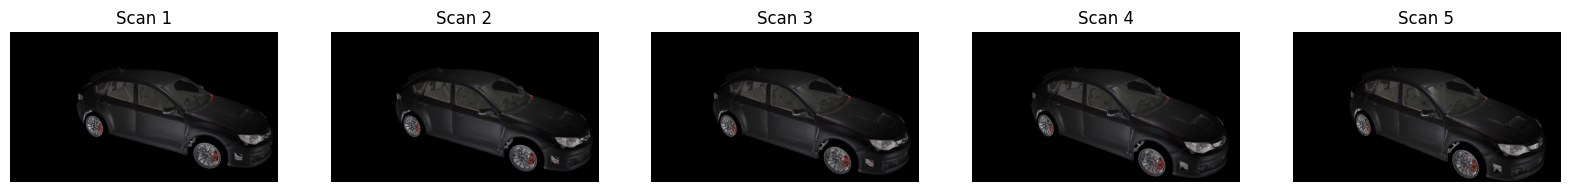

In [164]:

current_directory = os.getcwd()
print("Initial Working Directory:", current_directory)
print("Directory contents: ", os.listdir())
print("Checking existence ",os.chdir(r'/content/drive/MyDrive'))
#CHANGE TO YOUR DIRECTORY
test_path = r'/content/drive/MyDrive/carseg_data/carseg_data/images/black_5_doors/no_segmentation'



test_files = sorted(os.listdir(test_path))[20:25]
#first to train on small number to see if all works
# Iterate over the first five files and display the images and segmentations
i = 1
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for test_file in test_files:
    test_file_path = os.path.join(test_path, test_file)

    # Load and display the image
    img = Image.open(test_file_path)
    plt.subplot(1, 5, test_files.index(test_file) + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Scan {i}')


    i +=1

plt.show()


In [165]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform

        self.test_filenames = sorted(os.listdir(test_dir))

    def __len__(self):
        return len(self.test_filenames)

    def __getitem__(self, idx):
        test_path = os.path.join(self.test_dir, self.test_filenames[idx])

        test = Image.open(test_path).convert('L')  # Convert to grayscale

        if self.transform:
            test = self.transform(test)

        return {'test': test }

def custom_collate(batch):
    # Resize images and masks to a common size
    batch_size = len(batch)
    max_height = max(item['test'].shape[1] for item in batch)
    max_width = max(item['test'].shape[2] for item in batch)

    # Pad images and masks to the maximum size
    padded_images = [torch.nn.functional.pad(item['ct_scan'], pad=(0, max_width - item['ct_scan'].shape[2], 0, max_height - item['ct_scan'].shape[1])) for item in batch]

    # Stack padded images and masks
    stacked_images = torch.stack(padded_images)

    return {'test': stacked_images}

# Define your data transformation (adjust as needed)
transform_test = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

# Define your dataset instance
test_dataset = TestDataset(test_dir=test_path, transform=transform_test)

test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

(3, 256, 256)


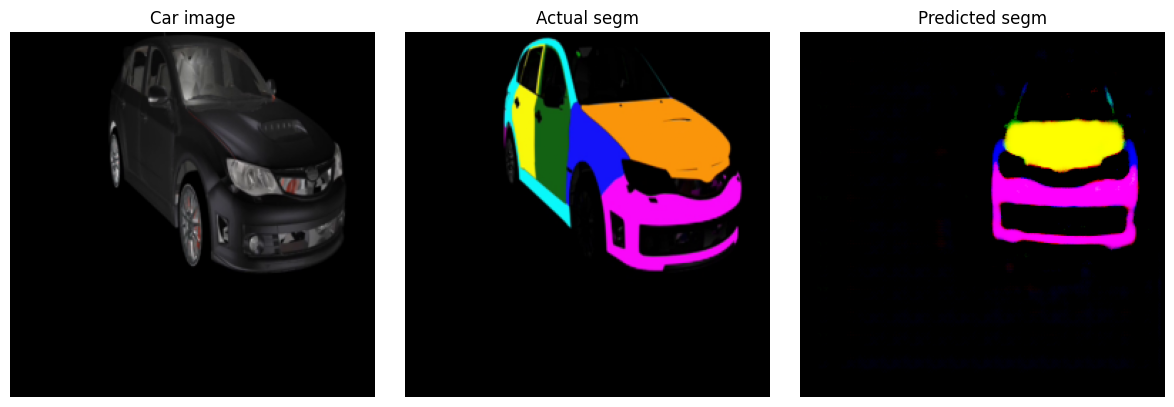

(3, 256, 256)


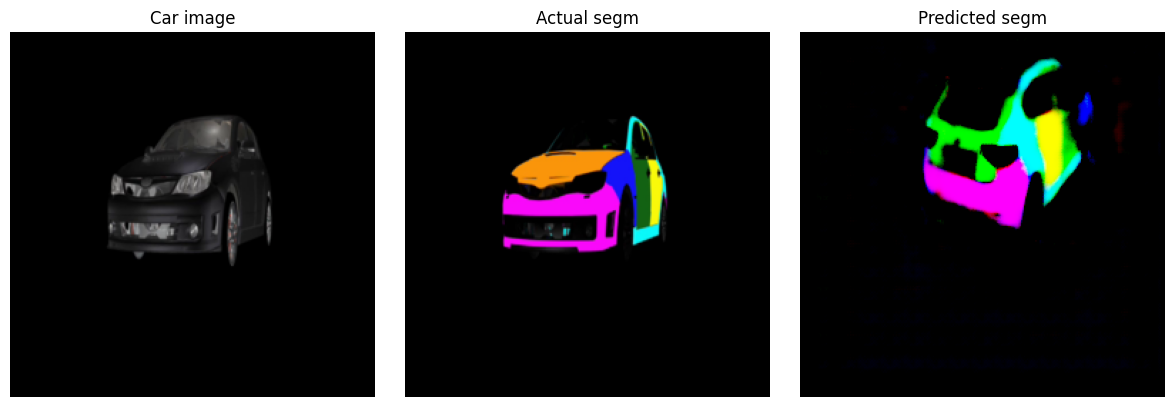

(3, 256, 256)


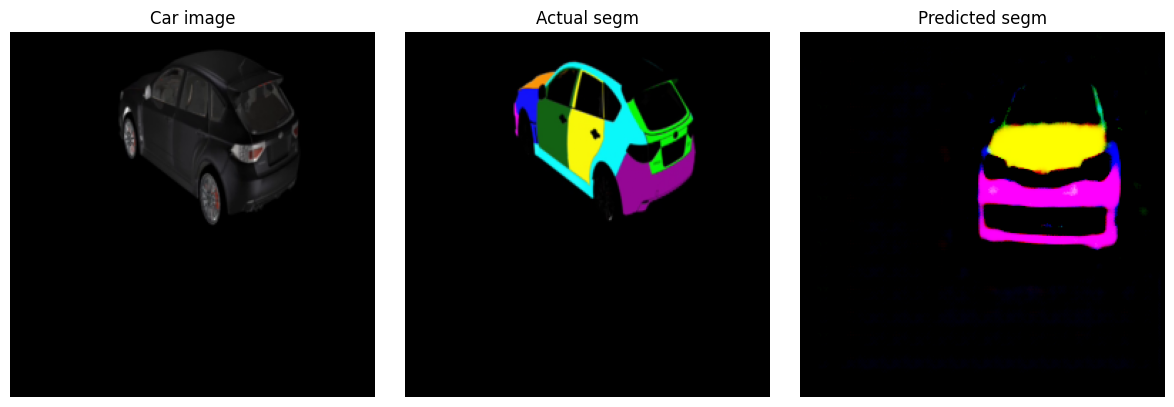

(3, 256, 256)


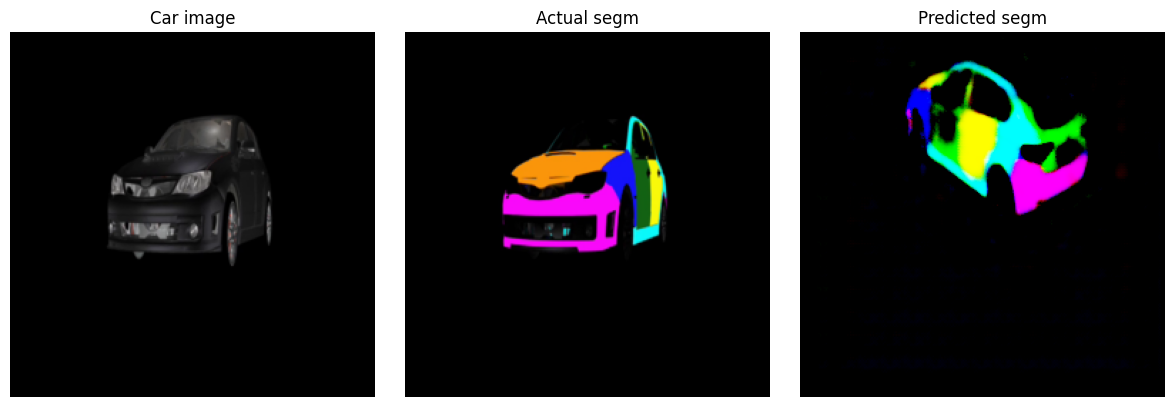

(3, 256, 256)


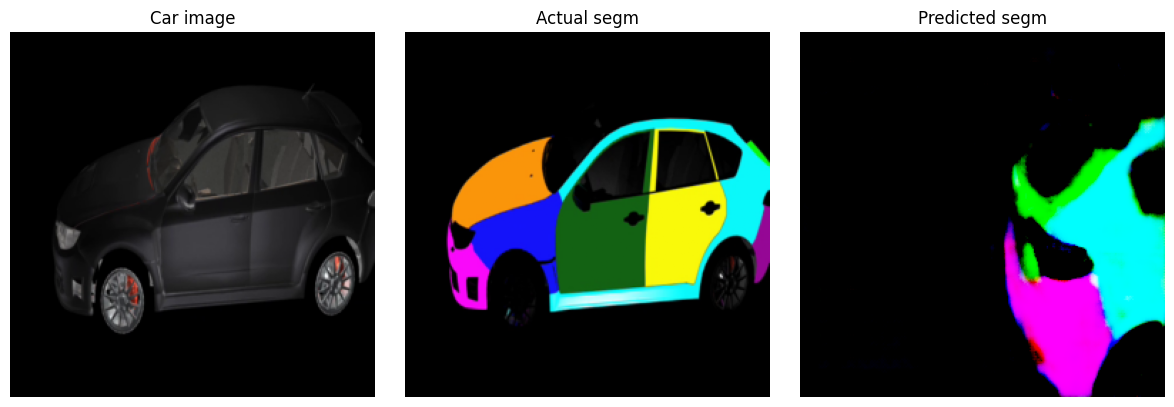

(3, 256, 256)


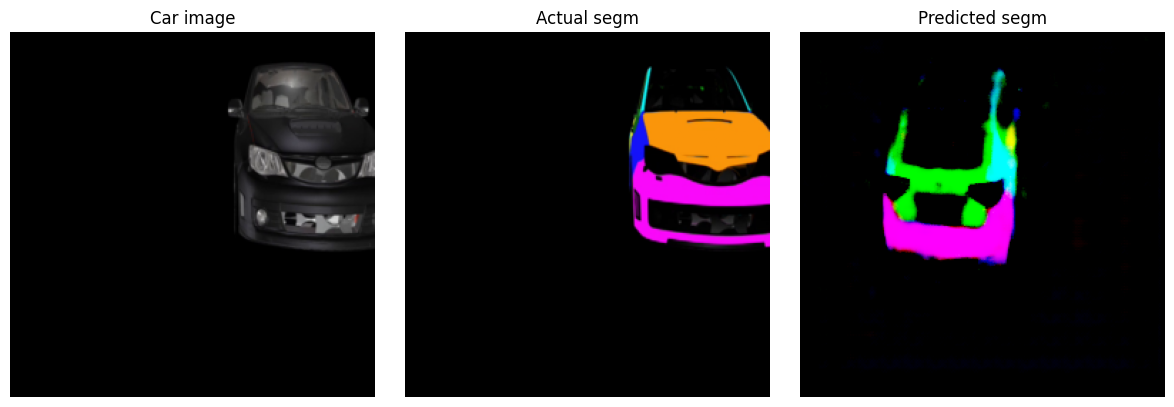

(3, 256, 256)


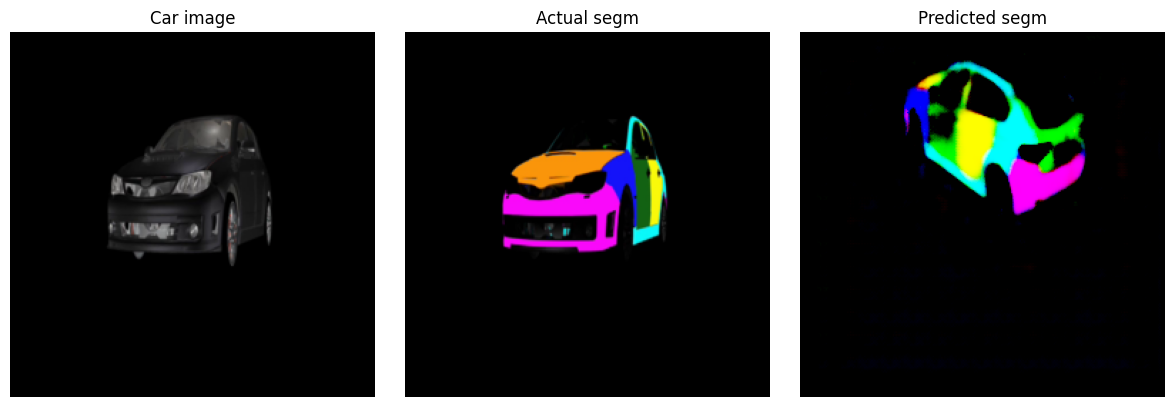

(3, 256, 256)


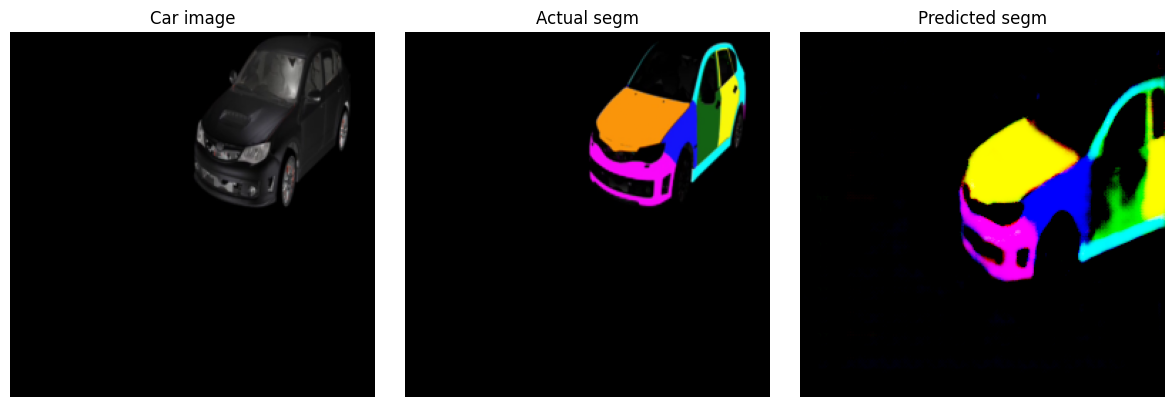

In [166]:
import matplotlib.pyplot as plt
def visualize_segmentation(model, valid_dl, num_samples=5):
    model.eval()  # Set model to evaluation mode

    sample_iterator = iter(valid_dl)

    data = next(sample_iterator)
    for i in range(8):
        car_scans = data['car'][i].cpu().numpy() # Assuming your model device is set correctly

        # Forward pass
        model.ct_scan = data['car']
        model.forward()
        segms = data['segm_mask'][i].cpu().numpy()
        # Get predicted masks (assuming you've used sigmoid activation in your model)
        predicted_masks = model.predicted_segm_mask[i].cpu().detach().numpy()

        plt.figure(figsize=(12, 4))

        # Display the original CT scan image
        plt.subplot(1, 3, 1)
        plt.title('Car image')
        plt.imshow(car_scans.transpose(1,2,0))  # Assuming grayscale CT scans
        plt.axis('off')

        # Display the actual segmentation mask
        plt.subplot(1, 3, 2)
        plt.title('Actual segm')
        plt.imshow(segms.transpose(1,2,0),cmap=car_cmap)  # Assuming grayscale masks
        plt.axis('off')

        # Display the predicted segmentation mask
        plt.subplot(1, 3, 3)
        plt.title('Predicted segm')
        print(predicted_masks.shape)
        plt.imshow(predicted_masks.transpose(1,2,0),cmap = car_cmap)  # Assuming grayscale masks
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Usage
visualize_segmentation(model, val_dl, num_samples=5)
